## Aircraft Engine Failure Prediction

This file includes steps to build a LSTM Model. Since any deep learning models require many hyperparameters, finding out the perfect architecture is very important. While there is no specific method for model architecture, We can rely on some rule of thumbs.

I follow tips suggested in this article: https://towardsdatascience.com/17-rules-of-thumb-for-building-a-neural-network-93356f9930af

### Importing Required Libraries and Data

In [2]:
import pandas as pd
import numpy as np
#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)
import time
import os
os.chdir("/Users/tomxu/Documents/NASA-Jet-Engine-Maintenance/Data/CMaps/")
from sklearn.preprocessing import MinMaxScaler #to normalize data
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score
#for deep learning
import tensorflow.keras
import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Masking, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import History
from tensorflow.keras import callbacks

In [3]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names
    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10',
                    'SensorMeasure14', 'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']
    df_train = pd.read_csv('train_FD001.txt',delim_whitespace=True,names=input_file_column_names)
    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)
    df_test = pd.read_csv('test_FD001.txt', delim_whitespace=True, names=input_file_column_names)
    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)
    y_true = pd.read_csv('RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index
    return df_train, df_test, y_true

In [4]:
df_train, df_test, y_true = prepare_data()
df_train.shape, df_test.shape, y_true.shape

((20631, 18), (13096, 17), (100, 2))

In [5]:
feats = df_train.columns.drop(['UnitNumber', 'Cycle', 'RUL'])

In [6]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])

In [7]:
# both the trainset and holdout set label are set to classify next 50 cycles 
df_train['failure'] = [1 if i < 50 else 0 for i in df_train.RUL]
y_true['failure'] = [1 if i < 50 else 0 for i in y_true.RUL]

In [8]:
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21,RUL,failure
0,1,1,-0.080460,-0.666667,-0.632530,-0.186396,-0.380486,0.452496,-0.515152,-0.780490,-0.261905,0.266525,-0.588235,-0.272028,-0.333333,0.426357,0.449323,191,0
1,1,2,0.218391,-0.500000,-0.433735,-0.093961,-0.294733,0.256039,-0.575758,-0.799515,-0.238095,0.530917,-0.441176,-0.177376,-0.333333,0.333333,0.462027,190,0
2,1,3,-0.494253,0.500000,-0.313253,-0.260955,-0.258947,0.420290,-0.454545,-0.719914,-0.500000,0.590618,-0.558824,-0.285110,-0.666667,0.255814,0.242751,189,0
3,1,4,0.080460,0.000000,-0.313253,-0.487683,-0.337610,0.481481,-0.363636,-0.750965,-0.666667,0.778252,-0.411765,-0.666795,-0.333333,0.147287,0.324772,188,0
4,1,5,-0.218391,-0.333333,-0.301205,-0.485066,-0.190749,0.336554,-0.515152,-0.700081,-0.488095,0.492537,-0.529412,-0.195845,-0.166667,0.178295,0.409003,187,0


In [9]:
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure15,SensorMeasure17,SensorMeasure20,SensorMeasure21
0,1,1,0.264368,0.500000,0.090361,-0.378679,-0.461175,0.304348,-0.575758,-0.744773,-0.583333,0.292111,-0.558824,-0.382070,-0.333333,0.116279,0.323667
1,1,2,-0.310345,-0.500000,-0.698795,-0.240898,-0.555368,0.610306,-0.666667,-0.706632,-0.226190,0.479744,-0.470588,-0.573682,-0.166667,0.364341,0.373654
2,1,3,0.034483,0.166667,-0.246988,-0.306736,-0.355503,0.371981,-0.545455,-0.683837,-0.226190,0.398721,-0.558824,-0.082724,-0.166667,0.457364,0.442695
3,1,4,0.482759,0.000000,-0.259036,-0.429693,-0.183997,0.359098,-0.606061,-0.788567,-0.488095,0.147122,-0.500000,-0.485956,-0.500000,0.333333,0.324220
4,1,5,0.160920,0.000000,-0.216867,-0.295836,-0.335922,0.388084,-0.666667,-0.795208,-0.452381,0.475480,-0.558824,-0.398230,-0.666667,0.317829,0.432753


In [10]:
y_true.head()

,RUL,UnitNumber,failure
0,112,0,0
1,98,1,0
2,69,2,0
3,82,3,0
4,91,4,0



LSTM expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [11]:
def gen_train(id_df, seq_length, seq_cols):
    """
        prepare train data into (samples, time steps, features) by moving window overlay
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])    
    return np.array(lstm_array)

In [12]:
def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

In [13]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = test dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value    
    id_df1 = pd.concat([df_mask, id_df],ignore_index=True)
    data_array = id_df1[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]    
    start = num_elements-seq_length
    stop = num_elements    
    lstm_array.append(data_array[start:stop, :])    
    return np.array(lstm_array)


Let's define look back period and mask_value

In [14]:
sequence_length = 50 #predicting using last 50 cycle values
mask_value = 0


Let's prepare data using above functions.

In [15]:
#generate train, look back is always agianst each unit's time series, get_train will reduce each unit's rows by 49
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(15731, 50, 15)


In [16]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "failure")) for unit in df_train['UnitNumber'].unique()))
y_train.shape

(15731,)

In [17]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 15)


In [17]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(100,)

In [18]:
nb_features = x_train.shape[2]
nb_out = 1

In [19]:
nb_features

15

In [20]:
class_0 = pd.Series(y_train).value_counts()[0]
class_1 = pd.Series(y_train).value_counts()[1]
total = class_0 + class_1
cls_wt = {0: class_1/total, 1: class_0/total}

In [21]:
cls_wt

{0: 0.3178437480134766, 1: 0.6821562519865234}

### Function to Print Results

In [22]:
def print_results(y_test, y_pred):    
    #f1-score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score: ", f1)
    print(classification_report(y_true.failure, y_pred))    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,12))
    plt.subplot(221)
    sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t - 0.5)
    plt.title('Confuion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')
    #roc_auc_score
    model_roc_auc = roc_auc_score(y_test, y_pred) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(y_test, y_pred)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    threshold = np.round(thresholds[ix],3)
    plt.subplot(222)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

### Model with 1 hidden layer

#### Model 1

In [23]:
history = History()
model1 = Sequential()
model1.add(LSTM(units=4, return_sequences=False, input_shape=(sequence_length, nb_features)))
model1.add(Dense(units=1, activation='sigmoid'))
model1.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model1.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 320       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 325
Trainable params: 325
Non-trainable params: 0
_________________________________________________________________


2022-10-04 15:54:39.040335: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-04 15:54:39.040470: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [24]:
%%time
# fit the model
model1.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1, 
           class_weight = cls_wt, callbacks = [history])

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100


2022-10-04 15:55:10.483118: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-04 15:55:10.483322: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-04 15:55:10.980595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 15:55:11.085996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 15:55:11.347772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


222/222 [==============================] - ETA: 0s - loss: 0.2172 - accuracy: 0.8325

2022-10-04 15:55:17.423513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 15:55:17.461178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


222/222 [==============================] - 7s 28ms/step - loss: 0.2172 - accuracy: 0.8325 - val_loss: 0.3594 - val_accuracy: 0.8888
Epoch 2/100
222/222 [==============================] - 6s 26ms/step - loss: 0.1451 - accuracy: 0.8896 - val_loss: 0.2901 - val_accuracy: 0.8977
Epoch 3/100
222/222 [==============================] - 6s 26ms/step - loss: 0.1094 - accuracy: 0.9213 - val_loss: 0.2566 - val_accuracy: 0.9034
Epoch 4/100
222/222 [==============================] - 6s 26ms/step - loss: 0.0951 - accuracy: 0.9260 - val_loss: 0.2325 - val_accuracy: 0.9142
Epoch 5/100
222/222 [==============================] - 6s 26ms/step - loss: 0.0862 - accuracy: 0.9308 - val_loss: 0.2082 - val_accuracy: 0.9168
Epoch 6/100
222/222 [==============================] - 6s 26ms/step - loss: 0.0791 - accuracy: 0.9333 - val_loss: 0.2571 - val_accuracy: 0.8888
Epoch 7/100
222/222 [==============================] - 6s 26ms/step - loss: 0.0727 - accuracy: 0.9362 - val_loss: 0.2233 - val_accuracy: 0.9161
Epoc

Text(0.5, 1.0, 'Loss')

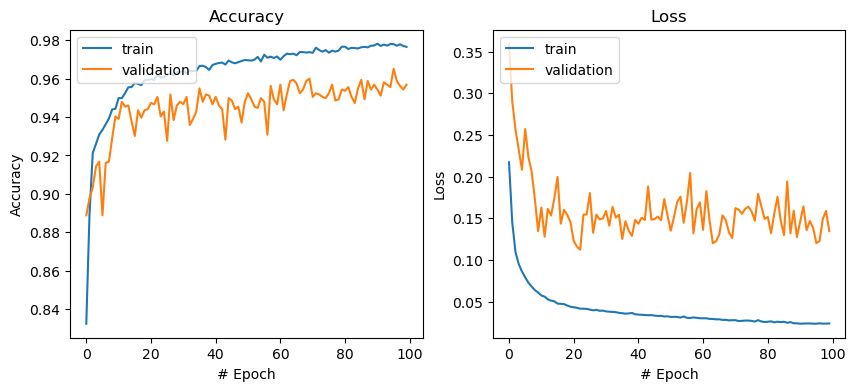

In [25]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')
# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

2022-10-04 16:07:22.648457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 16:07:22.678749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


F1 Score:  0.967741935483871
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        70
           1       0.94      1.00      0.97        30

    accuracy                           0.98       100
   macro avg       0.97      0.99      0.98       100
weighted avg       0.98      0.98      0.98       100

Area under curve :  0.9857142857142857 



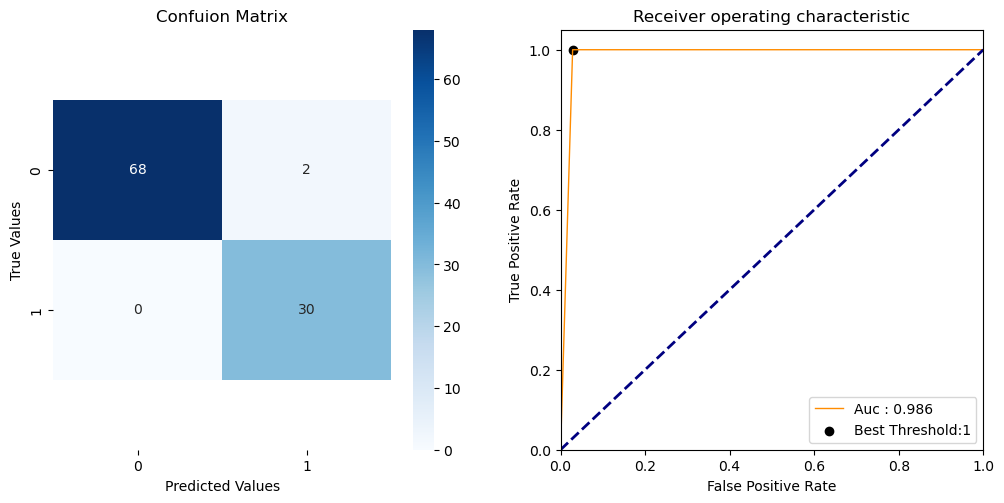

In [26]:
y_pred = (model1.predict(x_test) > 0.5).astype("int32")
print_results(y_true.failure, y_pred)

In [27]:
confusion_matrix(y_train, (model1.predict(x_train) > 0.5).astype("int32"))

array([[10559,   172],
       [  167,  4833]])

Even though we get very good results, there is an overfitting which can be seen in the Loss graph. After 25 epochs, the loss of validation set is increasing and loss of training set keeps on decreasing. Also, the accuracy of validation set remains constant after 25 epochs.

#### Model 2

Model 2 is same as Model 1 but the early stopping is implemented to stop overfitting. 

In [28]:
history = History()
model2 = Sequential()
model2.add(LSTM(units=4, return_sequences=False, input_shape=(sequence_length, nb_features)))
model2.add(Dense(units=1, activation='sigmoid'))
model2.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 320       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 325
Trainable params: 325
Non-trainable params: 0
_________________________________________________________________


In [29]:
%%time
# fit the model
model2.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
           callbacks = [history, callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/100


2022-10-04 16:10:43.942059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 16:10:44.044710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 16:10:44.188491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


222/222 [==============================] - ETA: 0s - loss: 0.2068 - accuracy: 0.8541

2022-10-04 16:10:50.320793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 16:10:50.360778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


222/222 [==============================] - 7s 29ms/step - loss: 0.2068 - accuracy: 0.8541 - val_loss: 0.3417 - val_accuracy: 0.8895
Epoch 2/100
222/222 [==============================] - 6s 26ms/step - loss: 0.1333 - accuracy: 0.8953 - val_loss: 0.2877 - val_accuracy: 0.8914
Epoch 3/100
222/222 [==============================] - 6s 26ms/step - loss: 0.1086 - accuracy: 0.9213 - val_loss: 0.2502 - val_accuracy: 0.9206
Epoch 4/100
222/222 [==============================] - 6s 26ms/step - loss: 0.1023 - accuracy: 0.9249 - val_loss: 0.2024 - val_accuracy: 0.9301
Epoch 5/100
222/222 [==============================] - 6s 26ms/step - loss: 0.0962 - accuracy: 0.9274 - val_loss: 0.2015 - val_accuracy: 0.9225
Epoch 6/100
222/222 [==============================] - 6s 26ms/step - loss: 0.0913 - accuracy: 0.9313 - val_loss: 0.1933 - val_accuracy: 0.9231
Epoch 7/100
222/222 [==============================] - 6s 26ms/step - loss: 0.0882 - accuracy: 0.9332 - val_loss: 0.1905 - val_accuracy: 0.9180
Epoc

Text(0.5, 1.0, 'Loss')

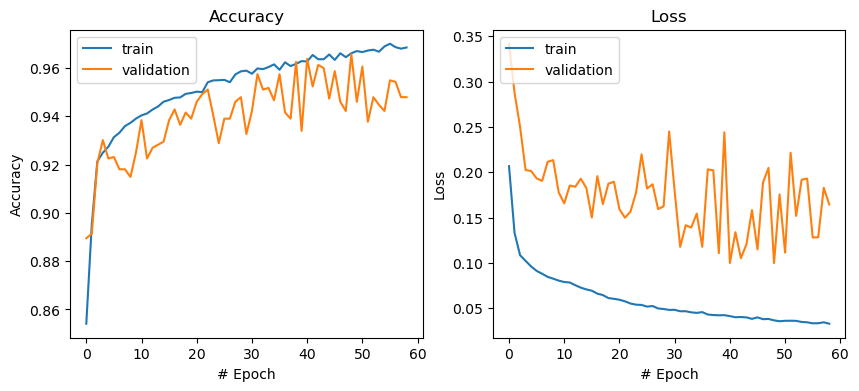

In [30]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')
# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

2022-10-04 16:28:02.683710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 16:28:02.716109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


F1 Score:  0.9375
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        70
           1       0.88      1.00      0.94        30

    accuracy                           0.96       100
   macro avg       0.94      0.97      0.95       100
weighted avg       0.96      0.96      0.96       100

Area under curve :  0.9714285714285714 



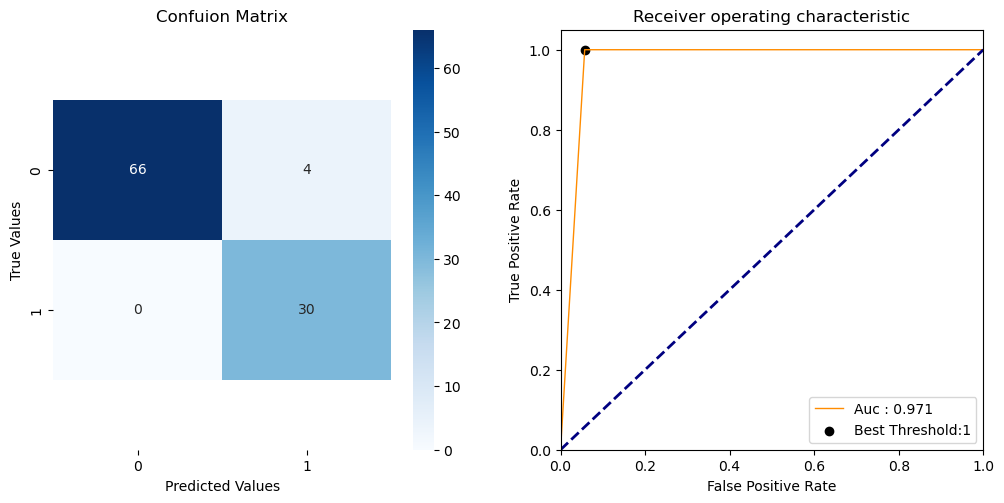

In [31]:
y_pred = (model2.predict(x_test) > 0.5).astype("int32")
print_results(y_true.failure, y_pred)

In [32]:
confusion_matrix(y_train, (model2.predict(x_train) > 0.5).astype("int32"))

array([[10336,   395],
       [  115,  4885]])

#### Model 3

Model 3 is same as Model 2 but dropout is added to further reduce overfitting. 

In [33]:
history = History()
model3 = Sequential()
model3.add(LSTM(units=4, return_sequences=False, input_shape=(sequence_length, nb_features)))
model3.add(Dropout(0.25))
model3.add(Dense(units=1, activation='sigmoid'))
model3.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4)                 320       
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 325
Trainable params: 325
Non-trainable params: 0
_________________________________________________________________


In [34]:
%%time
# fit the model
model3.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
           callbacks=[history, callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/100


2022-10-04 16:29:37.556060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 16:29:37.659848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 16:29:37.813002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


222/222 [==============================] - ETA: 0s - loss: 0.2025 - accuracy: 0.8555

2022-10-04 16:29:43.967601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 16:29:44.008917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


222/222 [==============================] - 7s 29ms/step - loss: 0.2025 - accuracy: 0.8555 - val_loss: 0.3512 - val_accuracy: 0.8780
Epoch 2/100
222/222 [==============================] - 6s 27ms/step - loss: 0.1448 - accuracy: 0.8892 - val_loss: 0.3186 - val_accuracy: 0.8577
Epoch 3/100
222/222 [==============================] - 6s 27ms/step - loss: 0.1164 - accuracy: 0.9149 - val_loss: 0.2466 - val_accuracy: 0.8996
Epoch 4/100
222/222 [==============================] - 6s 27ms/step - loss: 0.1072 - accuracy: 0.9163 - val_loss: 0.2311 - val_accuracy: 0.9028
Epoch 5/100
222/222 [==============================] - 6s 27ms/step - loss: 0.0991 - accuracy: 0.9241 - val_loss: 0.2115 - val_accuracy: 0.9187
Epoch 6/100
222/222 [==============================] - 6s 27ms/step - loss: 0.0941 - accuracy: 0.9263 - val_loss: 0.2549 - val_accuracy: 0.9066
Epoch 7/100
222/222 [==============================] - 6s 26ms/step - loss: 0.0908 - accuracy: 0.9289 - val_loss: 0.2240 - val_accuracy: 0.9149
Epoc

Text(0.5, 1.0, 'Loss')

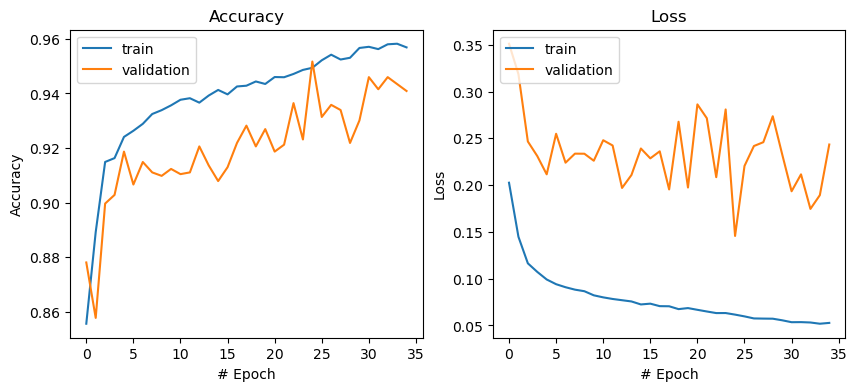

In [35]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')
# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

2022-10-04 16:37:19.997298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 16:37:20.026148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


F1 Score:  0.9375
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        70
           1       0.88      1.00      0.94        30

    accuracy                           0.96       100
   macro avg       0.94      0.97      0.95       100
weighted avg       0.96      0.96      0.96       100

Area under curve :  0.9714285714285714 



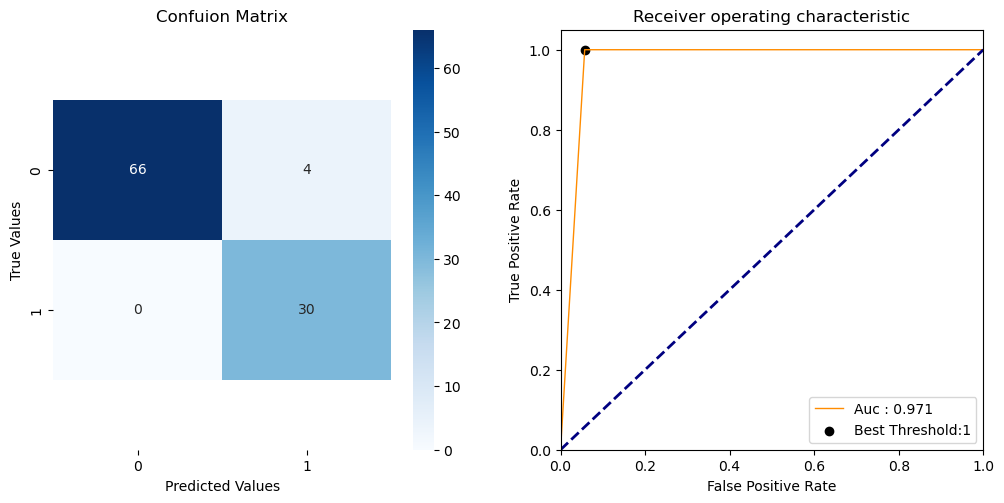

In [36]:
y_pred = (model3.predict(x_test) > 0.5).astype("int32")
print_results(y_true.failure, y_pred)

In [37]:
confusion_matrix(y_train, (model3.predict(x_train) > 0.5).astype("int32"))

array([[10239,   492],
       [  168,  4832]])

#### Model 4

Model 4 has two hidden layers to learn complex patterns in the data.

In [38]:
history = History()
model4 = Sequential()
model4.add(LSTM(units=8, return_sequences=True, input_shape=(sequence_length, nb_features)))
model4.add(Dropout(0.2))
model4.add(LSTM(units=4, return_sequences=False))
model4.add(Dropout(0.2))
model4.add(Dense(units=1, activation='sigmoid'))
model4.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 8)             768       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 8)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________


In [39]:
%%time
# fit the model
model4.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=1, class_weight = cls_wt,
           callbacks=[history, callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/100


2022-10-04 16:38:36.933598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 16:38:37.096952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 16:38:37.289452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 16:38:37.440231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 16:38:37.651992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


222/222 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.8416

2022-10-04 16:38:48.337180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 16:38:48.397622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 16:38:48.506984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


222/222 [==============================] - 13s 52ms/step - loss: 0.2151 - accuracy: 0.8416 - val_loss: 0.3831 - val_accuracy: 0.8710
Epoch 2/100
222/222 [==============================] - 10s 46ms/step - loss: 0.1504 - accuracy: 0.8872 - val_loss: 0.2958 - val_accuracy: 0.8888
Epoch 3/100
222/222 [==============================] - 10s 46ms/step - loss: 0.1420 - accuracy: 0.8856 - val_loss: 0.3099 - val_accuracy: 0.8831
Epoch 4/100
222/222 [==============================] - 10s 46ms/step - loss: 0.1245 - accuracy: 0.8993 - val_loss: 0.3054 - val_accuracy: 0.9041
Epoch 5/100
222/222 [==============================] - 10s 47ms/step - loss: 0.1159 - accuracy: 0.9087 - val_loss: 0.2390 - val_accuracy: 0.9060
Epoch 6/100
222/222 [==============================] - 10s 46ms/step - loss: 0.1204 - accuracy: 0.9072 - val_loss: 0.2911 - val_accuracy: 0.9015
Epoch 7/100
222/222 [==============================] - 10s 46ms/step - loss: 0.1178 - accuracy: 0.9152 - val_loss: 0.2740 - val_accuracy: 0.91

Text(0.5, 1.0, 'Loss')

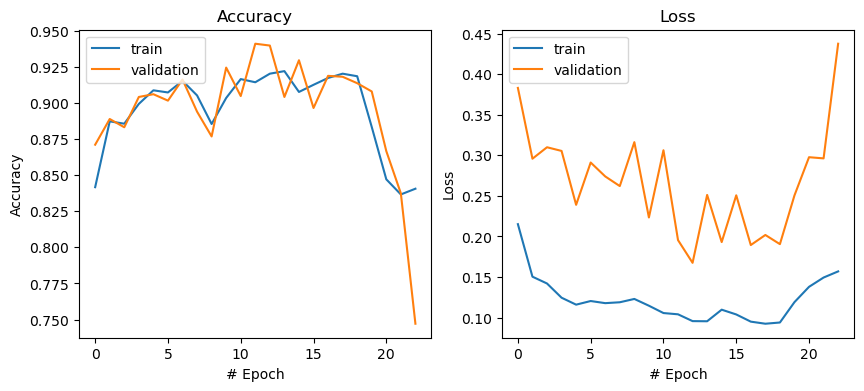

In [40]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'validation'], loc='upper left')
ax[0].set_title('Accuracy')
# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'validation'], loc='upper left')
ax[1].set_title('Loss')

2022-10-04 16:42:33.907849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 16:42:33.956289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 16:42:34.075518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


F1 Score:  0.7567567567567568
              precision    recall  f1-score   support

           0       0.96      0.77      0.86        70
           1       0.64      0.93      0.76        30

    accuracy                           0.82       100
   macro avg       0.80      0.85      0.81       100
weighted avg       0.87      0.82      0.83       100

Area under curve :  0.8523809523809525 



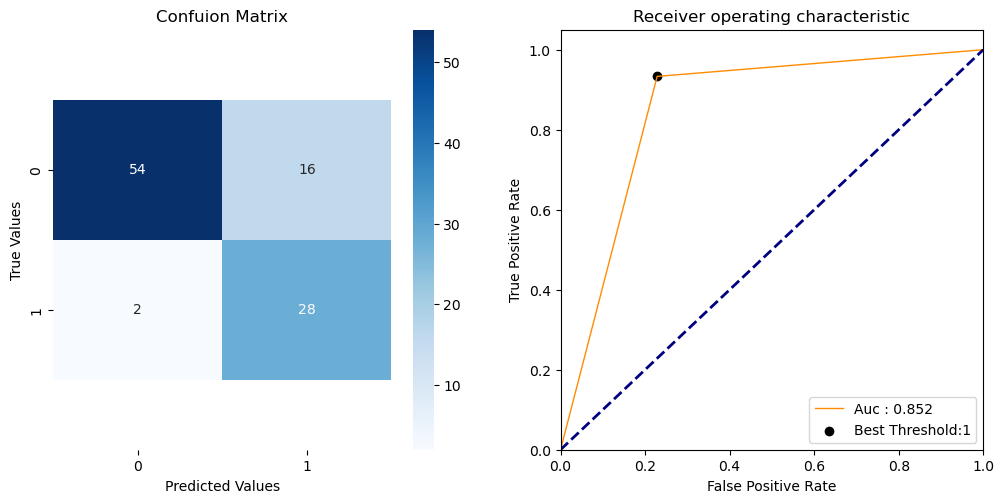

In [41]:
y_pred = (model4.predict(x_test) > 0.5).astype("int32")
print_results(y_true.failure, y_pred)

In [42]:
confusion_matrix(y_train, (model4.predict(x_train) > 0.5).astype("int32"))

array([[7823, 2908],
       [ 692, 4308]])

#### False Positives Analysis

In [43]:
y_true['pred'] = y_pred
y_true.head()

,RUL,UnitNumber,failure,pred
0,112,0,0,0
1,98,1,0,0
2,69,2,0,1
3,82,3,0,0
4,91,4,0,0


In [44]:
y_true[y_true.failure != y_true.pred]

,RUL,UnitNumber,failure,pred
2,69,2,0,1
9,96,9,0,1
10,97,10,0,1
12,95,12,0,1
24,145,24,0,1
31,48,31,1,0
32,106,32,0,1
37,50,37,0,1
40,18,40,1,0
44,114,44,0,1


The RUL for False positives is near to 50 cycles only.

### Experiment

LSTM models have stochasticity and the results might be different everytime. I run the model (architecture same as mdoel 4) 10 times and check the performance of model.

In [45]:
def run_exp_model(X, y, X_test, y_test, nruns = 10):    
    """
    Parameters:
    X, y = training pandas dataframe
    X_test, y_test = testing pandas dataframe
    nruns = number of time the models should rn    
    return:
    Dataframe with Model Run, Accuracy, Precision, Recall, F1 Score, AUC Score
    """    
    score_list = []
    for i in range(0, nruns):
        start = time.time()
        model = Sequential()
        model.add(LSTM(units=8, return_sequences=True, input_shape=(sequence_length, nb_features)))
        model.add(Dropout(0.2))
        model.add(LSTM(units=4, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(units=1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer = "adam", metrics=["accuracy"])
        model.fit(X, y, epochs=100, batch_size=64, validation_split=0.1, verbose=0, class_weight=cls_wt,
                  shuffle=True ,callbacks=[callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, 
                                                                   verbose=0, mode='auto')])
        predictions = (model.predict(x_test) > 0.5).astype("int32")
        acc = accuracy_score(y_test,predictions)
        pr = precision_score(y_test,predictions)
        rc = recall_score(y_test,predictions)
        f1 = f1_score(y_test,predictions)
        auc = roc_auc_score(y_test,predictions)
        score_list.append({'Model':i + 1, 'Accuracy': acc, 'Precision': pr,
                           'Recall': rc, 'F1 Score': f1, 'AUC Score': auc})
        end = time.time()
        print("Run:", i+1, " and Runtime:", np.round(end - start, 3), " Seconds", sep = "")
    score_df = pd.concat(score_list, columns=["Model", "Accuracy", "Precision", "Recall", "F1 score", "AUC Score"])
    return score_df

In [46]:
result_df = run_exp_model(x_train, y_train, x_test, y_true.failure, nruns = 10)

2022-10-04 16:56:20.865536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 16:56:21.031944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 16:56:21.172202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 16:56:21.324067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 16:56:21.539624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 16:56:31.923724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 16:56:31.985861: I tensorflow/core/grappler/optimizers/cust

Run:1 and Runtime:243.899 Seconds


2022-10-04 17:00:24.796972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:00:24.974618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:00:25.104555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:00:25.270817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:00:25.498421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:00:35.989750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:00:36.051062: I tensorflow/core/grappler/optimizers/cust

Run:2 and Runtime:205.235 Seconds


2022-10-04 17:03:50.359513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:03:50.575335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:03:50.698776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:03:50.857109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:03:51.083262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:04:01.379273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:04:01.439674: I tensorflow/core/grappler/optimizers/cust

Run:3 and Runtime:1022.894 Seconds


2022-10-04 17:20:52.864605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:20:53.030515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:20:53.152107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:20:53.331634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:20:53.578210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:21:04.165463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:21:04.225826: I tensorflow/core/grappler/optimizers/cust

Run:4 and Runtime:363.11 Seconds


2022-10-04 17:26:56.331911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:26:56.556602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:26:56.696212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:26:56.889993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:26:57.110053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:27:07.942286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:27:08.004692: I tensorflow/core/grappler/optimizers/cust

Run:5 and Runtime:215.708 Seconds


2022-10-04 17:30:31.675541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:30:31.840078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:30:31.976140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:30:32.168500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:30:32.392077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:30:42.932700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:30:42.991740: I tensorflow/core/grappler/optimizers/cust

Run:6 and Runtime:180.043 Seconds


2022-10-04 17:33:32.178183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:33:32.427550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:33:32.604736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:33:32.818206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:33:33.071871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:33:44.983987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:33:45.046961: I tensorflow/core/grappler/optimizers/cust

Run:7 and Runtime:995.811 Seconds


2022-10-04 17:50:07.532788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:50:07.711461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:50:07.847943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:50:08.033984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:50:08.268669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:50:18.839358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:50:18.899547: I tensorflow/core/grappler/optimizers/cust

Run:8 and Runtime:231.529 Seconds


2022-10-04 17:53:59.420538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:53:59.725981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:53:59.888867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:54:00.092835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:54:00.361459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:54:11.486853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 17:54:11.556170: I tensorflow/core/grappler/optimizers/cust

Run:9 and Runtime:772.091 Seconds


2022-10-04 18:06:51.144986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 18:06:51.311761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 18:06:51.443253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 18:06:51.639371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 18:06:51.907598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 18:07:02.554878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-04 18:07:02.616897: I tensorflow/core/grappler/optimizers/cust

Run:10 and Runtime:212.346 Seconds


/var/folders/50/zx6p2vtx3h9bvdft7b3h85sm0000gn/T/ipykernel_11172/17892379.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_df = score_df.append({'Model':i + 1, 'Accuracy': acc, 'Precision': pr, 'Recall': rc,


In [47]:
result_df

,Model,Accuracy,Precision,Recall,F1 score,AUC Score,F1 Score
0,1.0,0.89,0.806452,0.833333,NaN,0.873810,0.819672
1,2.0,0.91,0.920000,0.766667,NaN,0.869048,0.836364
2,3.0,0.93,0.896552,0.866667,NaN,0.911905,0.881356
3,4.0,0.94,0.852941,0.966667,NaN,0.947619,0.906250
4,5.0,0.96,1.000000,0.866667,NaN,0.933333,0.928571
5,6.0,0.73,0.528302,0.933333,NaN,0.788095,0.674699
6,7.0,0.90,0.833333,0.833333,NaN,0.880952,0.833333
7,8.0,0.88,0.909091,0.666667,NaN,0.819048,0.769231
8,9.0,0.85,0.674419,0.966667,NaN,0.883333,0.794521
9,10.0,0.89,0.806452,0.833333,NaN,0.873810,0.819672


Text(0, 0.5, 'Value')

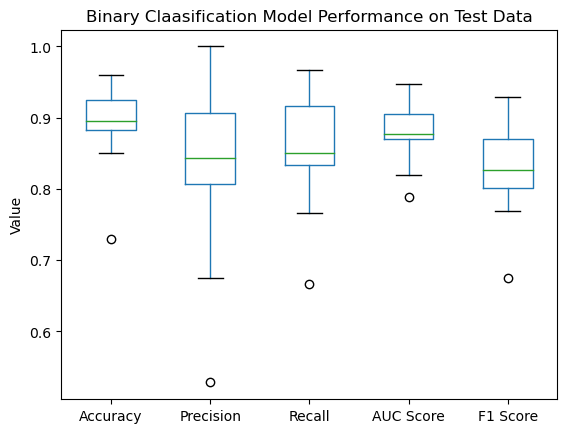

In [49]:
fig, ax = plt.subplots()
result_df.drop(['Model'], axis = 1).boxplot(vert = 1, ax = ax)
ax.set_title('Binary Claasification Model Performance on Test Data')
ax.grid(visible=None)
ax.set_ylabel('Value')

In [50]:
result_df.mean()

Model        5.500000
Accuracy     0.888000
Precision    0.822754
Recall       0.853333
F1 score          NaN
AUC Score    0.878095
F1 Score     0.826367
dtype: float64